1、Multiple ensembles shown to work. Analysis of why one ensemble performs better or worse than others.
2、Analysis of interaction between hyperparameters and ensemble composition.
3、Analysis of interaction between training/validation/testing and ensembles and hyperparameters.
4、ROC created and all models/ensembles plotted on the same graph. ROC index calculated.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [5]:
# Number of instances: 2535
# Number of attributes: 73 attributes  

df_data1 = pd.read_csv('ozone_eighthr.csv')
df_data1.replace(['?'],[0], inplace =True)
df_data1.fillna(0, inplace =True)
df_data1.iloc[:3]

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Orzone
0,01/01/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0.0,0
1,01/02/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0.0,0
2,01/03/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0.0,0


In [6]:
df_data2 = pd.read_csv("ozone_onehr.csv")
df_data2.replace(['?'],[0], inplace =True)
df_data2.fillna(0, inplace =True)
df_data2.iloc[:3]

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Orzone
0,01/01/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0.0,0
1,01/02/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0.0,0
2,01/03/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0.0,0


In [7]:
df_data1.groupby('Orzone')['Orzone'].count()

Orzone
0    2374
1     160
Name: Orzone, dtype: int64

In [8]:
df_data2.groupby('Orzone')['Orzone'].count()

Orzone
0    2463
1      73
Name: Orzone, dtype: int64

In [9]:
def func(df_data, alpha):
    X_train, X_test, y_train, y_test = train_test_split(\
                            df_data.iloc[:, 1:-1].values, 
                            df_data.iloc[:, -1].values, 
                            test_size=alpha, 
                            random_state=42)
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = func(df_data1, 0.4)

In [11]:
clf1 = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.01,
                                 max_depth=5,
                                 random_state=0)
clf2 = RandomForestClassifier(n_estimators=100)

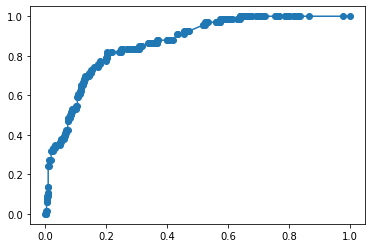

0.8628292417849381


In [14]:
clf1.fit(X_train, y_train)
y_pre = clf1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                          y_pre,
                                          )
plt.plot(fpr,tpr,marker = 'o')
plt.show()
auc_score1 = metrics.roc_auc_score(y_test,y_pre)
print(auc_score1)

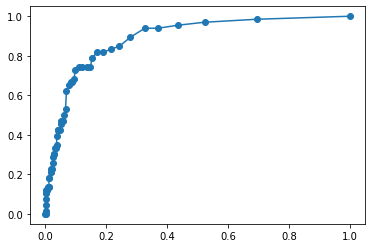

0.8898158803222095


In [15]:
clf2.fit(X_train, y_train)
y_pre = clf2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                          y_pre,
                                          )
plt.plot(fpr,tpr,marker = 'o')
plt.show()
auc_score1 = metrics.roc_auc_score(y_test,y_pre)
print(auc_score1)